In [1]:
 !pip install transformers

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sa-bangla-binary-restaurant-review/Bert_Preprocessed_Restaurant_Review_Dataset.xlsx


In [3]:
import tensorflow as tf
import logging
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
    LSTM,
    Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
import numpy as np
import keras
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
import re
import random
import torch

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
max_length = 100
batch_size = 32
test_size = 0.1
num_class = 2

In [6]:
model_name = "sagorsarker/bangla-bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [7]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 341.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
df=pd.read_excel('/kaggle/input/sa-bangla-binary-restaurant-review/Bert_Preprocessed_Restaurant_Review_Dataset.xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1431 non-null   int64 
 1   Unnamed: 0.1  1431 non-null   int64 
 2   Reviews       1431 non-null   object
 3   Sentiment     1431 non-null   object
 4   Text          1431 non-null   object
 5   Label         1431 non-null   int64 
 6   Token         1431 non-null   object
 7   Token_ID      1431 non-null   object
dtypes: int64(3), object(5)
memory usage: 89.6+ KB


In [9]:
#df=df.drop_duplicates(subset=['Text'],inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Token'],df['Label'] , test_size=0.1, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1, random_state=2)

In [11]:
x_train = x_train.astype(str)
#y_train = y_train.astype(str)
x_validation = x_validation.astype(str)
x_test = x_test.astype(str)
#y_test = y_test.astype(str)

In [12]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(
        data, max_length=max_length, padding="max_length", truncation=True
    )
    return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(x_train)
validation_encoded=bert_encode(x_validation)
test_encoded = bert_encode(x_test)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, y_train))
    .shuffle(100)
    .batch(batch_size)
).cache()
validation_dataset = (
    tf.data.Dataset.from_tensor_slices((validation_encoded,y_validation))
    .shuffle(100)
    .batch(batch_size)
).cache()

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_encoded,y_test))
    .shuffle(100)
    .batch(batch_size)
).cache()


2022-04-17 20:11:00.166979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:11:00.168099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:11:00.168787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:11:00.169699: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
from keras.utils.vis_utils import plot_model

In [14]:
def bert_bangla_sentiment_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]
    #clf_output = Flatten()(last_hidden_states)
    net= Conv1D(200, kernel_size=3, activation = "relu")(last_hidden_states)
    net = Bidirectional(LSTM(128, return_sequences=True))(net)
    net = Bidirectional(LSTM(64))(net)
    net = Dense(512, activation="relu")(net)
    net = Dropout(0.5)(net)
    net = Dense(256, activation="relu")(net)
    net = Dropout(0.4)(net)
    net = Dense(128, activation="relu")(net)
    net = Dropout(0.3)(net)
    net = Dense(64, activation="relu")(net)
    net = Dropout(0.2)(net)
    net = Dense(32, activation="relu")(net)
    net = Dropout(0.1)(net)
    net = Dense(16, activation="relu")(net)
    net = Dropout(0.1)(net)
    net = Flatten()(net)
    output = Dense(1, activation="sigmoid")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [15]:
with strategy.scope():
    model = bert_bangla_sentiment_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(
        loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"]
    )
    model.summary()

Downloading:   0%|          | 0.00/930M [00:00<?, ?B/s]

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 164396544 
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 200)           461000    
_________________________________________________________________
bidirectional (Bidirectional (None, 98, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0     

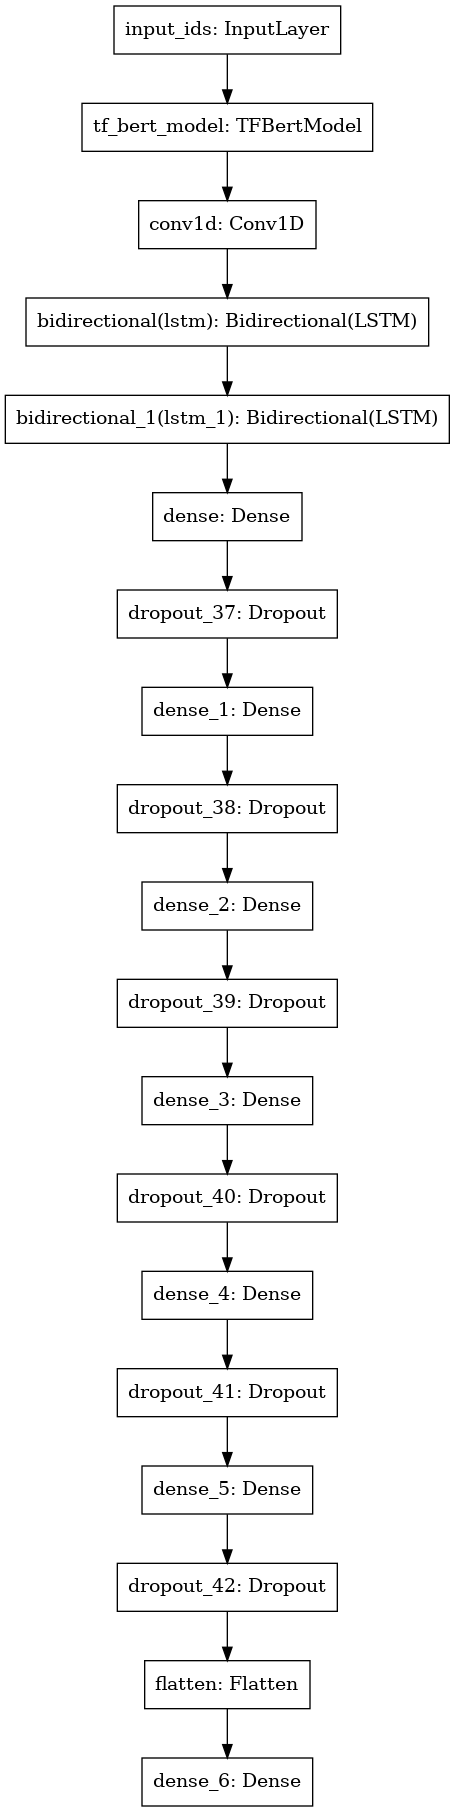

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [17]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=30,
    validation_data=validation_dataset,
    verbose=1,
)

Epoch 1/30


2022-04-17 20:12:36.816443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-17 20:12:41.112185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 43s 521ms/step - loss: 0.6910 - accuracy: 0.5328 - val_loss: 0.6873 - val_accuracy: 0.6357
Epoch 2/30
37/37 [==============================] - 16s 421ms/step - loss: 0.6919 - accuracy: 0.5216 - val_loss: 0.6893 - val_accuracy: 0.6047
Epoch 3/30
37/37 [==============================] - 16s 424ms/step - loss: 0.6875 - accuracy: 0.5561 - val_loss: 0.6854 - val_accuracy: 0.6202
Epoch 4/30
37/37 [==============================] - 16s 422ms/step - loss: 0.6881 - accuracy: 0.5440 - val_loss: 0.6843 - val_accuracy: 0.6357
Epoch 5/30
37/37 [==============================] - 16s 426ms/step - loss: 0.6875 - accuracy: 0.5484 - val_loss: 0.6823 - val_accuracy: 0.6279
Epoch 6/30
37/37 [==============================] - 16s 422ms/step - loss: 0.6900 - accuracy: 0.5397 - val_loss: 0.6811 - val_accuracy: 0.6357
Epoch 7/30
37/37 [==============================] - 16s 422ms/step - loss: 0.6898 - accuracy: 0.5518 - val_loss: 0.6834 - val_accuracy: 0.6279
Epoch 8/30

In [18]:
#model.save_weights('weights.h5', overwrite=True)

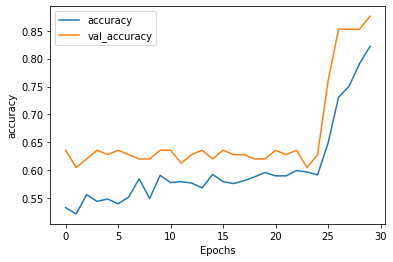

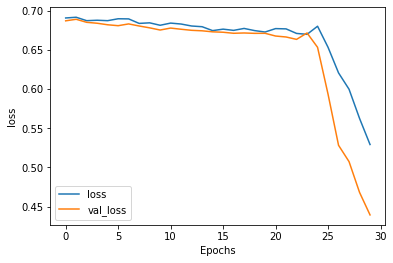

In [19]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
from sklearn.metrics import classification_report
y_pred=model.predict(test_dataset, batch_size=batch_size)
y_pred = np.round(y_pred)

In [21]:
y_pred = y_pred.reshape(-1,1)

In [22]:
categories = ['negative','positive']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

    negative       0.53      0.48      0.51        85
    positive       0.34      0.39      0.37        59

    accuracy                           0.44       144
   macro avg       0.44      0.44      0.44       144
weighted avg       0.45      0.44      0.45       144



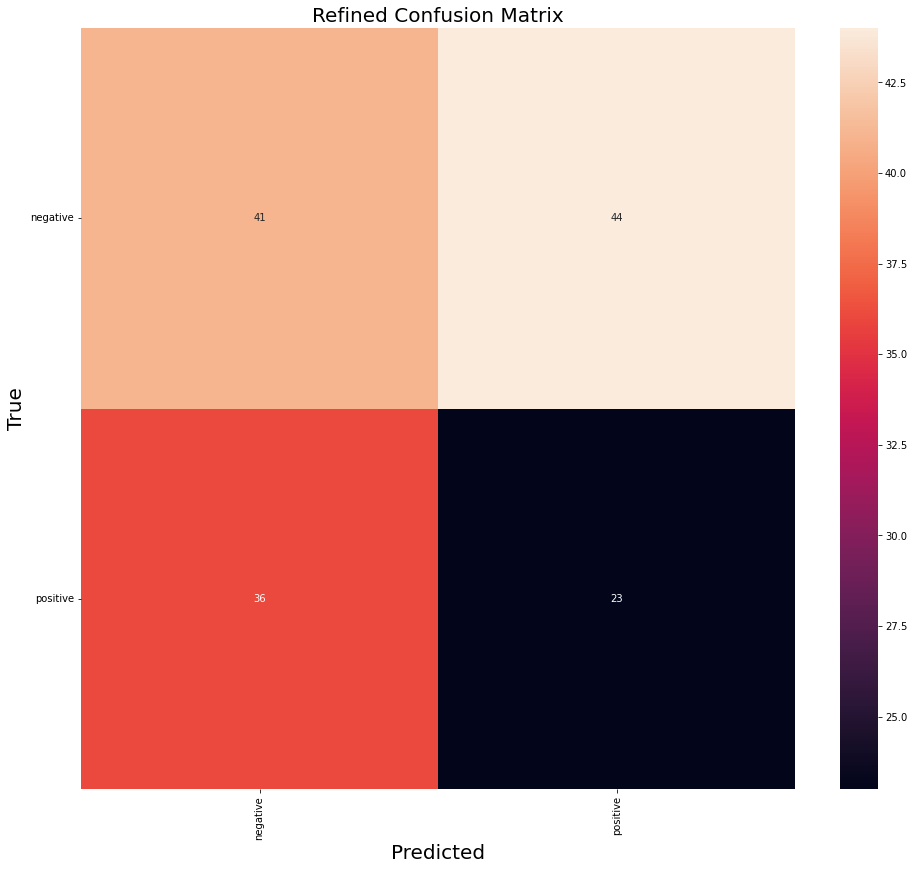

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 2
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [24]:
Influenced by:
Kaggle Notebook:https://www.kaggle.com/code/lmasca/disaster-tweets-using-bert-embeddings-and-lstm/notebook

SyntaxError: invalid syntax (840428899.py, line 1)